In [17]:
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import gmsh

from funcionesFEM import ResolverSistemaFEM, graficar_armadura1
from comandoGmsh import ResolverSistemaGmesh

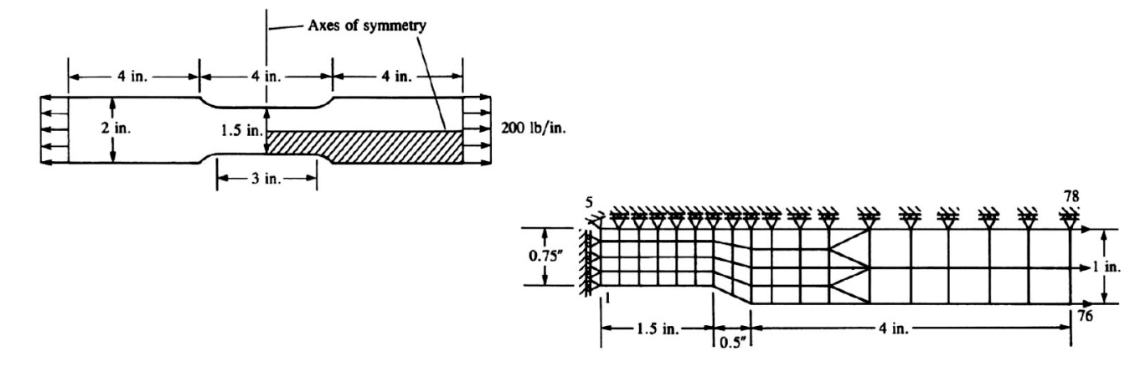

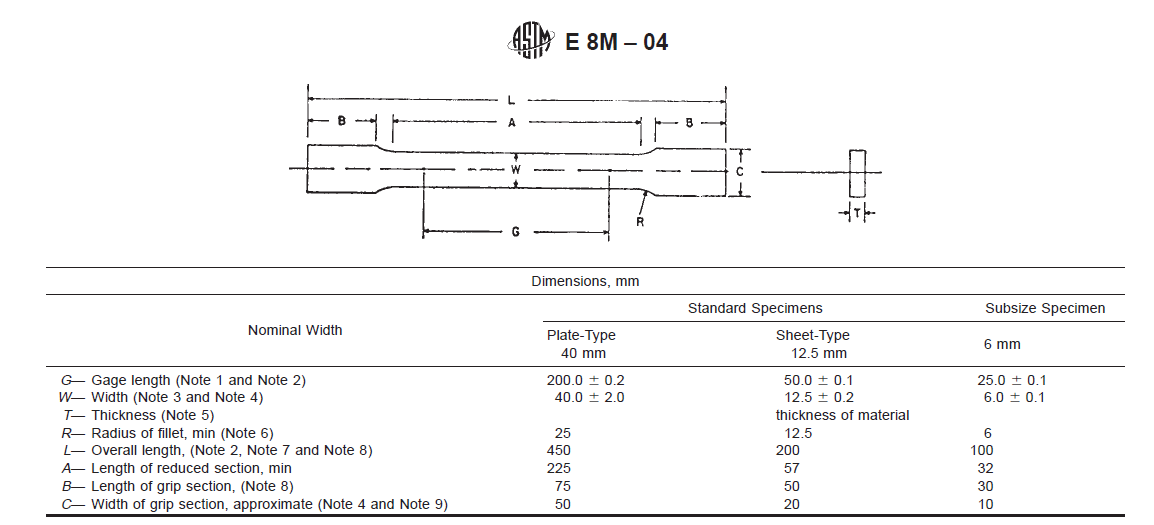

In [18]:
class DATOS:
    def __init__(self, id,ancho, espesor, Tension, ModuloElastico, ModuloPoison, glxn, FactorEscala, EscalaMallado):
        self.id = id                # Indice del elemento                 
        self.ancho = ancho
        self.espesor = espesor               
        self.Tension = Tension             
        self.ModuloElastico = ModuloElastico  
        self.ModuloPoison = ModuloPoison      
        self.glxn = glxn
        self.FactorEscala = FactorEscala
        self.EscalaMallado = EscalaMallado    

In [19]:
Dato = DATOS(id=1,ancho = 10, espesor=2, Tension=500, ModuloElastico=210e3, ModuloPoison=0.3, glxn = 2, FactorEscala = 100, EscalaMallado = 2)

In [20]:
#   Lo que se hace ahora es dibujar la pieza con los comandos internos de gmesh

gmsh.initialize()           #   Para inicial gmsh
gmsh.model.add('EJ2-P1')    #   Se arma el modelo

#   Se dibuja la pieza

#   Defino los puntos

esc = Dato.EscalaMallado 

P = [
    gmsh.model.geo.addPoint(0,0,0,esc),
    gmsh.model.geo.addPoint(0,6.25,0,esc),
    gmsh.model.geo.addPoint(41.0732,6.25,0,esc/10),
    gmsh.model.geo.addPoint(50,10,0,esc/10),    
    gmsh.model.geo.addPoint(100,10,0,esc),
    gmsh.model.geo.addPoint(100,0,0,esc),
    gmsh.model.geo.addPoint(41.0732,18.75,0,0)
]

L = [
    gmsh.model.geo.addLine(P[2],P[1]),
    gmsh.model.geo.addLine(P[1],P[0]),
    gmsh.model.geo.addLine(P[0],P[5]),
    gmsh.model.geo.addLine(P[5],P[4]),
    gmsh.model.geo.addLine(P[4],P[3]),
    gmsh.model.geo.addCircleArc(P[2],P[6],P[3])
]

#   Defino las curvas cerradas de mi modelo

C1 = gmsh.model.geo.addCurveLoop([L[0],L[1],L[2],L[3],L[4]])
C2 = gmsh.model.geo.addCurveLoop([L[5]])

#   Defino que curvas van a conformar una superficie

S1 = gmsh.model.geo.addPlaneSurface([C1,C2])

gmsh.model.geo.synchronize()
gmsh.model.mesh.generate(2)
#gmsh.fltk.run()

In [21]:
 #   Se definen los elementos que van a tener propiedades fisicas

EmpotradoX = gmsh.model.addPhysicalGroup(1, [L[1]])
gmsh.model.setPhysicalName(1, EmpotradoX, 'EmpotradoX')

EmpotradoY = gmsh.model.addPhysicalGroup(1, [L[2]])
gmsh.model.setPhysicalName(1, EmpotradoY, 'EmpotradoY')

TraccionadoX = gmsh.model.addPhysicalGroup(1, [L[3]])
gmsh.model.setPhysicalName(1, TraccionadoX, 'TraccionadoX')

Superficie = gmsh.model.addPhysicalGroup(2, [S1])
gmsh.model.setPhysicalName(2, Superficie, 'Superficie')

NodoCentro = gmsh.model.addPhysicalGroup(0, [P[6]])
gmsh.model.setPhysicalName(0, NodoCentro, 'NodoCentro')

In [22]:
MN, MC, b, Nodos, Elementos = ResolverSistemaGmesh (Dato,EmpotradoY, EmpotradoX, TraccionadoX, NodoCentro)
U,F,elementos = ResolverSistemaFEM(MN,MC,b,Dato,False)

#...........................................................................................................

UMatriz = U.reshape(-1, 2)
UMatriz = np.hstack((UMatriz, np.zeros((UMatriz.shape[0], 1))))

TensionMexPE = np.array([e.TensionMax for e in elementos])
TensionX = np.array([e.Tension[0] for e in elementos])
TensionY = np.array([e.Tension[1] for e in elementos])

desplazamientos = gmsh.view.add("Desplazamientos")
gmsh.view.addModelData(desplazamientos, 0, 'EJ2-P1', 'NodeData', Nodos[0], UMatriz, numComponents = 3)

TensionesMaxPE = gmsh.view.add("Tensioes maximas")
gmsh.view.addModelData(TensionesMaxPE, 0, 'EJ2-P1', 'ElementData', Elementos[0], TensionMexPE, numComponents = 1)

TensionesX = gmsh.view.add("Tensioes en X")
gmsh.view.addModelData(TensionesX, 0, 'EJ2-P1', 'ElementData', Elementos[0], TensionX, numComponents = 1)

TensionesY = gmsh.view.add("Tensioes en Y")
gmsh.view.addModelData(TensionesY, 0, 'EJ2-P1', 'ElementData', Elementos[0], TensionY, numComponents = 1)

gmsh.fltk.run()
gmsh.finalize()

In [23]:
# fig1, ax1 = plt.subplots(figsize=(10, 6))

# graficar_armadura1(ax1, MN, MC, 'Estructura Original', color='gray', linestyle='-')
    
# plt.tight_layout()
# plt.show()